In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from collections import Counter
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
import joblib


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/prime_videos.csv')

In [ ]:
df.head(3)

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,description,price,categories
0,5,Five Stars,"Amazon, please buy the show! I'm hooked!",B013488XFS,B013488XFS,2015-08-24 03:07:17.000,True,Prime Video,Sneaky Pete,4.6,56658.0,['A\xa0con man (Giovanni Ribisi) on the run fr...,NaN,Suspense
1,5,Five Stars,My Kiddos LOVE this show!!,B00CB6VTDS,B00CB6VTDS,2016-04-19 21:16:50.000,True,Prime Video,Creative Galaxy,4.8,6403.0,['Follow the adventures of Arty and his sideki...,NaN,Kids
2,5,What Love Is...,"...isn't always how you expect it to be, but w...",B001H1SVZC,B001H1SVZC,2020-05-28 04:13:47.074,True,Prime Video,NaN,4.5,389.0,NaN,NaN,NaN


In [ ]:
df.tail(3)

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,description,price,categories
233607,5,Another Instant Will Ferrell Classic!!!,Will Ferrell has always been one of my favorit...,B00V9US0TI,B00V9US0TI,2015-03-28 02:27:19.000,False,Prime Video,NaN,4.6,13355.0,NaN,NaN,NaN
233608,5,Scary Movie 5 is Easily One of the Best in the...,I grew up with the Scary Movie franchise. I've...,B00EAZL6HC,B00EAZL6HC,2013-08-20 02:43:44.000,False,Prime Video,NaN,4.3,3125.0,NaN,NaN,NaN
233609,4,Pretty Good!!!,This movie was a lot better than I had expecte...,B002VXKYCS,B002VXKYCS,2009-12-31 01:25:26.000,False,Prime Video,NaN,4.8,5742.0,NaN,NaN,NaN


In [ ]:
df.shape

(233610, 14)

- The dataset consists of **233,610 rows** and **14 columns**.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233610 entries, 0 to 233609
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             233610 non-null  int64  
 1   title_x            233586 non-null  object 
 2   text               233579 non-null  object 
 3   asin               233610 non-null  object 
 4   parent_asin        233610 non-null  object 
 5   timestamp          233610 non-null  object 
 6   verified_purchase  233610 non-null  bool   
 7   main_category      233610 non-null  object 
 8   title_y            33800 non-null   object 
 9   average_rating     233607 non-null  float64
 10  rating_number      233607 non-null  float64
 11  description        33800 non-null   object 
 12  price              24165 non-null   float64
 13  categories         33800 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(9)
memory usage: 23.4+ MB


## Key Observations

- **Missing Values:** Some columns, such as `title_y`, `description`, `price`, and `categories`, have a large number of missing values.

- **Data Types:**
  - Numeric: `rating` (integer), `average_rating` (float), `rating_number` (float), and `price` (float).
  - Text: `title_x`, `text`, `asin`, `parent_asin`, `timestamp`, `main_category`, `title_y`, `description`, and `categories`.
  - Boolean: `verified_purchase`.
- **Potential Issues:**
  - `timestamp` is stored as an object (string) and may need to be converted to a datetime format.
  - The `price` column has a significant amount of missing data.

In [ ]:
#check for missing values
df.isna().sum()

,0
rating,0
title_x,24
text,31
asin,0
parent_asin,0
timestamp,0
verified_purchase,0
main_category,0
title_y,199810
average_rating,3


## Key Observations

1. **Minimal Missing Data**: Columns like `rating`, `asin`, `timestamp`, `verified_purchase`, and `main_category` have no missing values.
2. **Moderate Missing Data**: `title_x`, `text`, `average_rating`, and `rating_number` have only a few missing values.
3. **Significant Missing Data**:
   - `title_y`, `description`, and `categories` have **over 85% missing values**, meaning these features may not be useful unless imputed or removed.
   - `price` has the **highest number of missing values (209,445)**, making it largely unreliable for analysis.

## Next Steps
- **For features with few missing values** (`title_x`, `text`, `average_rating`, etc.), imputation or dropping the missing rows could be viable.
- **For highly missing features** (`title_y`, `description`, `price`, `categories`), we consider:
  - Removing them if they are not critical.
  - Imputing with placeholders or external data sources if necessary.

This analysis helps determine which features are useful and which might need cleaning before further processing.

In [ ]:
df.duplicated().sum()

538

- We have **538** entries which are duplicated. We will drop the duplicates in data cleaning

In [ ]:
# create a copy of the dataset
data = df.copy()

## Data cleaning

In this part I will clean the data to make it good for use in exploratory data analysis and modelling.

This will involve:
- Removing `null` and inconsistent values.
- Removing `duplicates` in the data.
- Performing text preprocessing, such as `removing stopwords`, `tokenization`, and applying `stemming or lemmatization`.

In [ ]:
# removing all nulls
data = data.dropna()
data.shape

(24164, 14)

- After dropping all null values we have 24164 rows.

In [ ]:
data.duplicated().sum()

52

In [ ]:
data = data.drop_duplicates()
data.shape

(24112, 14)

In [ ]:
data.head(3)

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,description,price,categories
14,4,Four Stars,It was pretty good. Had some pretty comical sc...,B01KBKKU7G,B01KBKKU7G,2016-09-16 18:39:49.000,True,Prime Video,Seven Girlfriends,3.2,333.0,"[""Jesse has never had a problem finding a gir...",12.99,Comedy
19,3,Ok love story,A bit slow and an unsatisfying ending,B01M0S0C8M,B01M0S0C8M,2016-11-08 22:14:17.000,True,Prime Video,Still Mine,4.6,4744.0,"[""James Cromwell gives a tour de force perform...",9.99,Drama
21,1,TRASH,A movie based solely on INCEST. Storyline is g...,B00G2TAAVM,B00G2TAAVM,2022-08-22 20:06:25.847,True,Prime Video,How I Live Now,4.3,907.0,"['Set in the near-future UK, Saoirse Ronan pla...",12.99,International


In [ ]:
data.columns

Index(['rating', 'title_x', 'text', 'asin', 'parent_asin', 'timestamp',
       'verified_purchase', 'main_category', 'title_y', 'average_rating',
       'rating_number', 'description', 'price', 'categories'],
      dtype='object')

In [ ]:
# select and drop insignificant columns
cols_to_drop = ['asin', 'parent_asin', 'main_category', 'title_y', 'rating_number',
                'description', 'price']
data = data.drop(cols_to_drop, axis=1)

In [ ]:
data.shape

(24112, 7)

In [ ]:
# Convert timestamp to datetime format
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Extract useful time components
data["year"] = data["timestamp"].dt.year
data["month"] = data["timestamp"].dt.to_period("M")  # Month-Year format
data["day"] = data["timestamp"].dt.date

In [ ]:
data.shape

(24112, 10)

In [ ]:
data.head(2)

,rating,title_x,text,timestamp,verified_purchase,average_rating,categories,year,month,day
14,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49,True,3.2,Comedy,2016,2016-09,2016-09-16
19,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17,True,4.6,Drama,2016,2016-11,2016-11-08


In [ ]:
# change title_x column to be just title

data = data.rename(columns={'title_x': 'title'})
data.columns


Index(['rating', 'title', 'text', 'timestamp', 'verified_purchase',
       'average_rating', 'categories', 'year', 'month', 'day'],
      dtype='object')

In [ ]:
# Assign a sentiment label based on the rating value
data["sentiment"] = data["rating"].apply(
    lambda x:
        "negative" if x <= 2 else  # If rating is 1 or 2, classify as "negative"
        "neutral" if x == 3 else   # If rating is 3, classify as "neutral"
        "positive"                 # If rating is 4 or 5, classify as "positive"
)

In [ ]:
data.head(2)

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment
14,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49,True,3.2,Comedy,2016,2016-09,2016-09-16,positive
19,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17,True,4.6,Drama,2016,2016-11,2016-11-08,neutral


In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data['text'][:3]

,text
0,It was pretty good. Had some pretty comical sc...
1,A bit slow and an unsatisfying ending
2,A movie based solely on INCEST. Storyline is g...


In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [ ]:
data['text'] = data['text'].apply(strip_html_tags)
data['text'][:3]

,text
0,It was pretty good. Had some pretty comical sc...
1,A bit slow and an unsatisfying ending
2,A movie based solely on INCEST. Storyline is g...


## EDA

In this section I will check for the counts and lengths including:

- Character counts
- word count
- mean word length
- mean sentence length.

I will also perform visualizations of the most common words and display some bigrams and trigrams

### Checking length of reviews

Analysing length of reviews offers some good advantages especially in sentiment analysis. Review length helps us in:

1. Understanding Review Quality & Detail
  - Short Reviews (e.g., "Great product!")
    - may lack detailed insights.
    - Could be more biased toward extreme sentiments (either very positive or very negative).

  - Long Reviews (e.g., a paragraph of feedback)

    - Provide richer insights about the movie.
    

This will help us filter out uninformative short reviews before analysis.

2. Identifying Fake or Spam Reviews
  - Very short reviews (e.g., "Good," "Nice") can sometimes be spam or bot-generated.
  - Overly long reviews with repetitive phrases might indicate fake promotional content.

This will help us detect and remove low-quality reviews.

3. Impact on Sentiment Analysis
  - Short reviews might have stronger sentiment words ("Terrible!", "Amazing!").
  - Longer reviews might contain nuanced opinions ("The product is great, but shipping was slow.").


4. Improving Text Summarization
  - Summarization models perform better when trained on longer reviews with meaningful content.
  - Short reviews may not need summarization.
  
  This will aid us to apply summarization techniques only to lengthy reviews.

5. Optimizing Preprocessing & Storage
  - Very long reviews might slow down NLP models, increasing processing time.
  - Trimming excessively long reviews can optimize storage & computation.




In [ ]:
# check for the length of a review
data['text'][0]

'It was pretty good. Had some pretty comical scenes throughout. A great chick flick.'

In [ ]:
length_sample = len(data['text'][0])
print(f'Length of a sample review: {length_sample}')

Length of a sample review: 83


In [ ]:
data['Length'] = data['text'].str.len()
data.head(3)

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment,Length
0,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49.000,True,3.2,Comedy,2016,2016-09,2016-09-16,positive,83
1,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17.000,True,4.6,Drama,2016,2016-11,2016-11-08,neutral,37
2,1,TRASH,A movie based solely on INCEST. Storyline is g...,2022-08-22 20:06:25.847,True,4.3,International,2022,2022-08,2022-08-22,negative,82


In [ ]:
# create a function for box plots
def box_plot(df, col):
    fig, ax = plt.subplots(figsize=(8,7))
    sns.boxplot(x="sentiment", y=col, data=df)
    plt.title(f"Boxplot of {col} by Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel(col)
    plt.xticks(rotation=45);

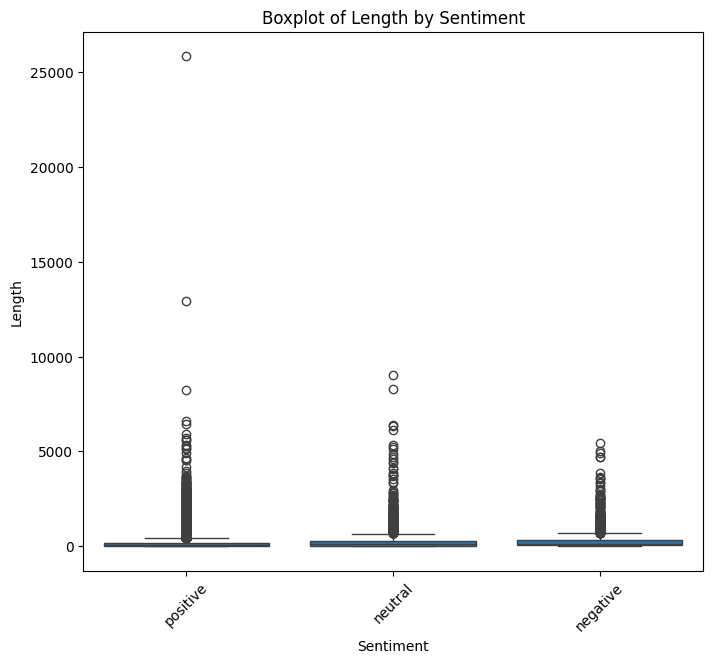

In [ ]:
box_plot(data, 'Length')

### Word Count
- This entails number of words in a review

Advantages of word counts include:

1. Identifying Review Quality
  - Short reviews (1-5 words) → Often vague ("Good", "Bad", "Works well")
  - Medium-length reviews (10-50 words) → More informative but still concise
  - Long reviews (50+ words) → Typically more detailed.

2. Enhancing Sentiment Analysis
  - Short reviews might have stronger polarity ("Terrible!" = negative, "Amazing!" = positive).
  - Longer reviews may contain mixed sentiment or more detail about the movie.

In [ ]:
word_count = data['text'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 14


In [ ]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [ ]:
data['Word_count'] = data['text'].apply(word_count)
data.head()

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment,Length,Word_count
0,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49.000,True,3.2,Comedy,2016,2016-09,2016-09-16,positive,83,14
1,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17.000,True,4.6,Drama,2016,2016-11,2016-11-08,neutral,37,7
2,1,TRASH,A movie based solely on INCEST. Storyline is g...,2022-08-22 20:06:25.847,True,4.3,International,2022,2022-08,2022-08-22,negative,82,14
3,5,Five Stars,Excellent!!!,2016-01-25 18:47:06.000,True,4.8,Science Fiction,2016,2016-01,2016-01-25,positive,12,1
4,2,Not what it used to be,This used to be a favorite of mine but I just ...,2018-12-03 16:52:02.089,True,4.6,Suspense,2018,2018-12,2018-12-03,negative,505,95


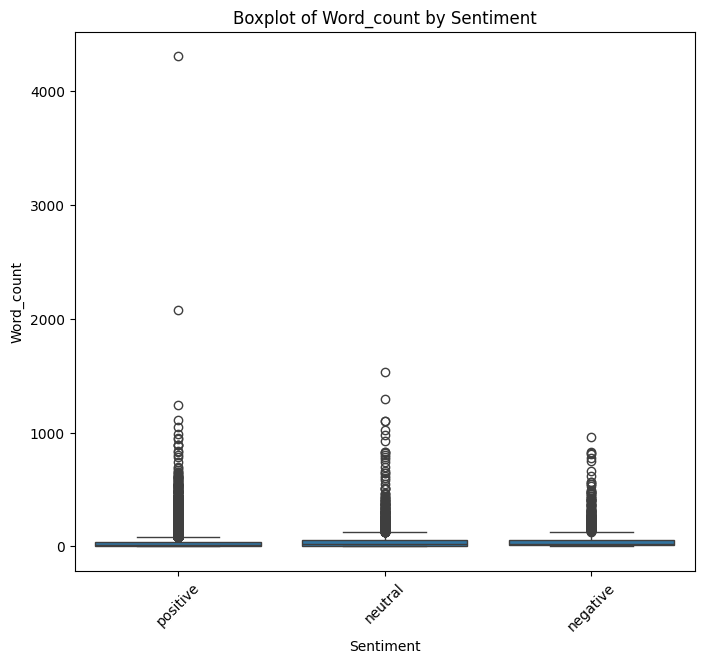

In [ ]:
box_plot(data, 'Word_count')

### Mean word length
- This is the average length of words

In [ ]:
data['mean_word_length'] = data['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head()

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment,Length,Word_count,mean_word_length
0,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49.000,True,3.2,Comedy,2016,2016-09,2016-09-16,positive,83,14,5.000000
1,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17.000,True,4.6,Drama,2016,2016-11,2016-11-08,neutral,37,7,4.428571
2,1,TRASH,A movie based solely on INCEST. Storyline is g...,2022-08-22 20:06:25.847,True,4.3,International,2022,2022-08,2022-08-22,negative,82,14,4.928571
3,5,Five Stars,Excellent!!!,2016-01-25 18:47:06.000,True,4.8,Science Fiction,2016,2016-01,2016-01-25,positive,12,1,12.000000
4,2,Not what it used to be,This used to be a favorite of mine but I just ...,2018-12-03 16:52:02.089,True,4.6,Suspense,2018,2018-12,2018-12-03,negative,505,95,4.326316


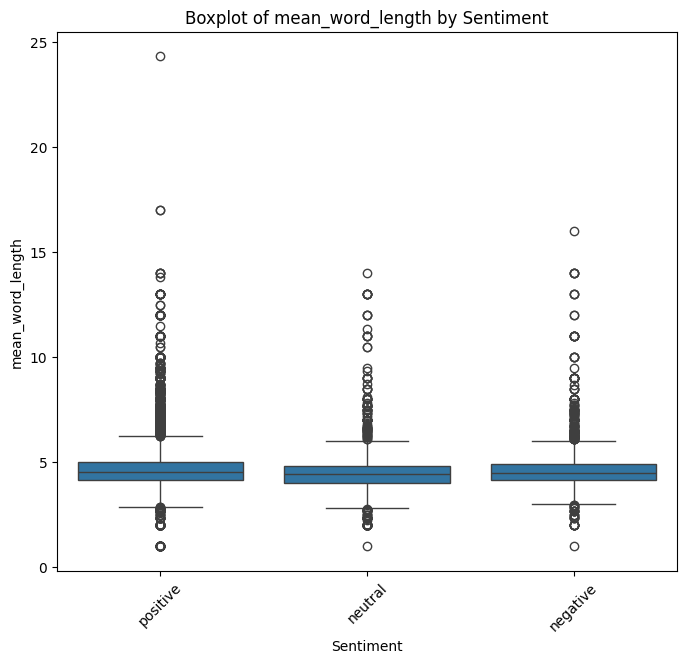

In [ ]:
box_plot(data, 'mean_word_length')

In [ ]:
def count_plot(df, col):
    """
    Creates a count plot for a given column.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col (str): The column to visualize.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette="viridis")

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45);  # Rotate labels for better readability

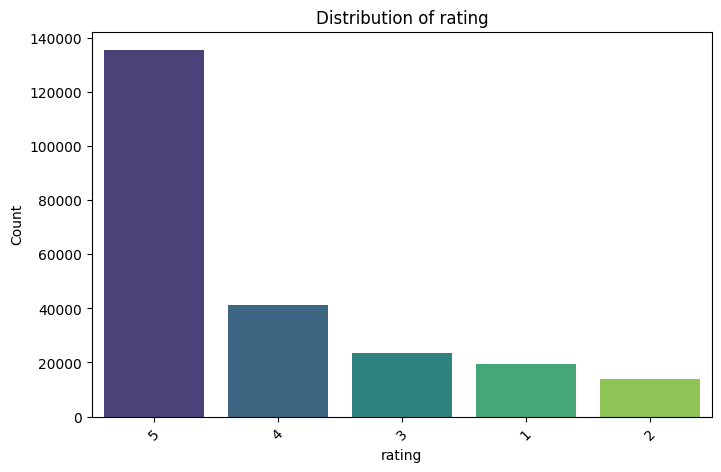

In [ ]:
count_plot(df, "rating")

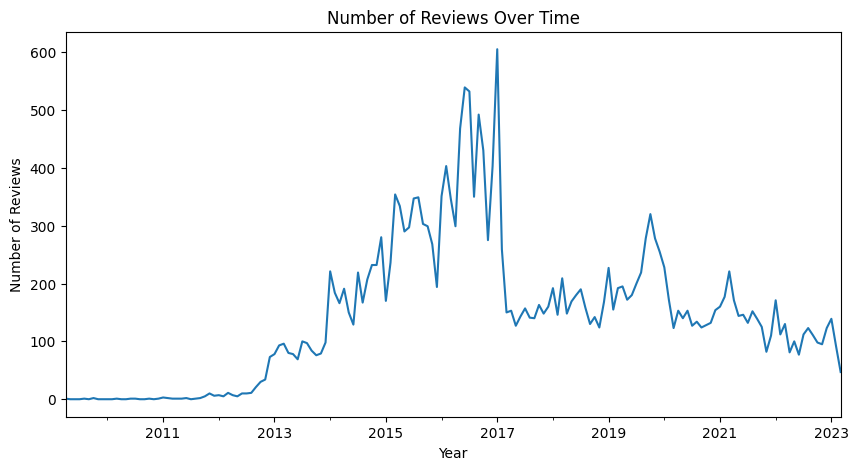

In [ ]:
plt.figure(figsize=(10, 5))
data.set_index("timestamp")["rating"].resample("M").count().plot()
plt.title("Number of Reviews Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

<Figure size 1200x600 with 0 Axes>

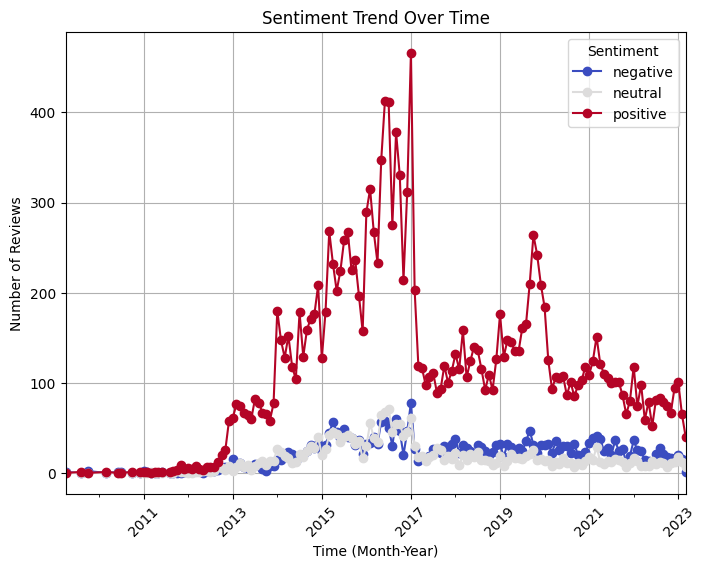

In [ ]:
# Group by month and count sentiment types
sentiment_trend = data.groupby(["month", "sentiment"]).size().unstack().fillna(0)

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
sentiment_trend.plot(kind="line", marker="o", figsize=(8, 6), colormap="coolwarm")
plt.title("Sentiment Trend Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(True)
plt.show();

<Figure size 1200x600 with 0 Axes>

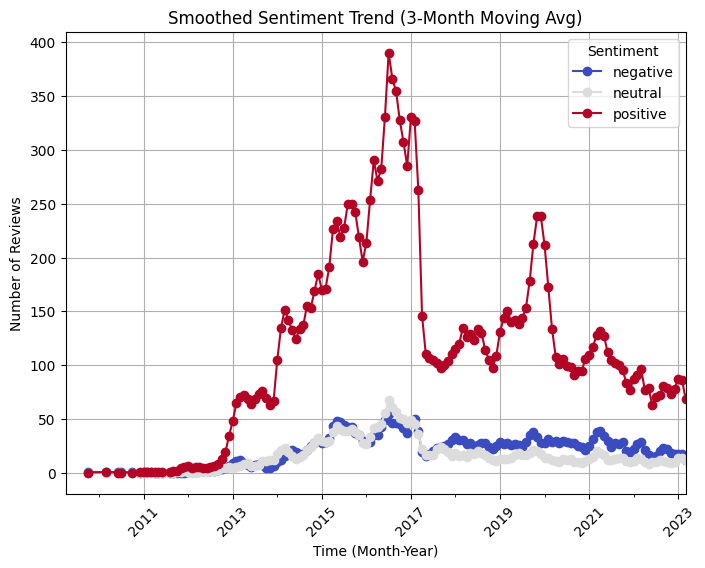

In [ ]:
# Compute rolling mean (3-month moving average)
sentiment_trend_smooth = sentiment_trend.rolling(3).mean()

# Plot smoothed trends
plt.figure(figsize=(12, 6))
sentiment_trend_smooth.plot(kind="line", marker="o", figsize=(8, 6), colormap="coolwarm")
plt.title("Smoothed Sentiment Trend (3-Month Moving Avg)")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(True)
plt.show();

In [ ]:
wpt = WordPunctTokenizer()
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = wpt.tokenize(doc)

    # filter stopwords out of document
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [ ]:
data["clean_review"] = data["text"].apply(normalize_document)

In [ ]:
data.head(3)

,rating,title,text,timestamp,verified_purchase,average_rating,categories,year,month,day,sentiment,Length,Word_count,mean_word_length,clean_review
0,4,Four Stars,It was pretty good. Had some pretty comical sc...,2016-09-16 18:39:49.000,True,3.2,Comedy,2016,2016-09,2016-09-16,positive,83,14,5.000000,pretty good pretty comical scene throughout gr...
1,3,Ok love story,A bit slow and an unsatisfying ending,2016-11-08 22:14:17.000,True,4.6,Drama,2016,2016-11,2016-11-08,neutral,37,7,4.428571,bit slow unsatisfying ending
2,1,TRASH,A movie based solely on INCEST. Storyline is g...,2022-08-22 20:06:25.847,True,4.3,International,2022,2022-08,2022-08-22,negative,82,14,4.928571,movie based solely incest storyline garbage ac...


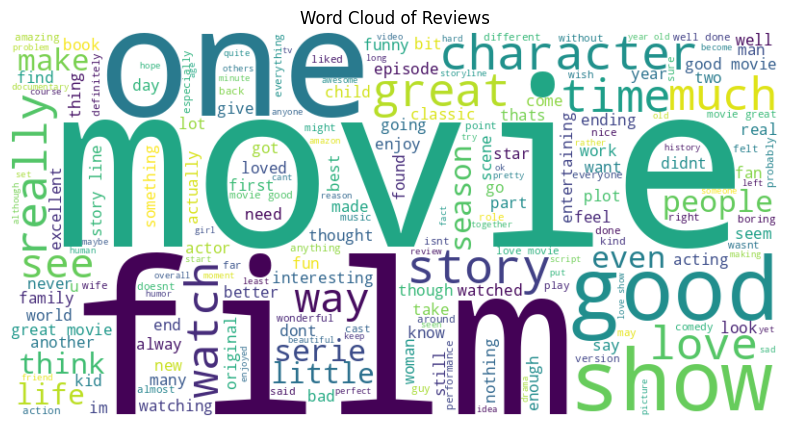

In [ ]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(data["clean_review"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show();


In [ ]:
positive_reviews = " ".join(data[data["sentiment"] == "positive"]["clean_review"].astype(str))
negative_reviews = " ".join(data[data["sentiment"] == "negative"]["clean_review"].astype(str))

In [ ]:
positive_reviews[:30]

'pretty good pretty comical sce'

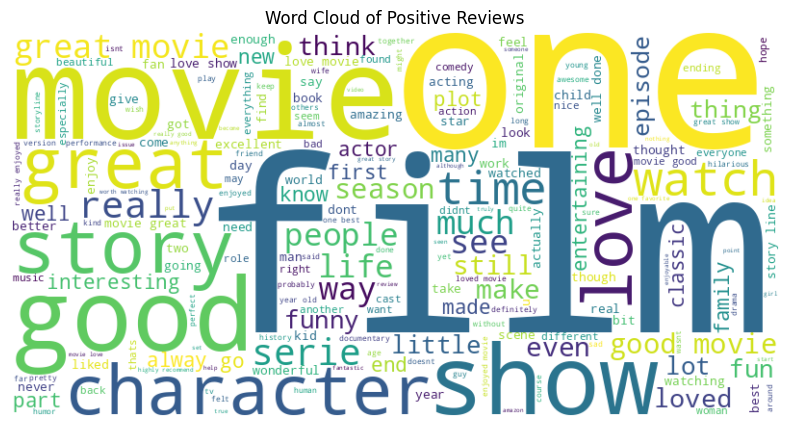

In [ ]:
pos_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Reviews")
plt.show();

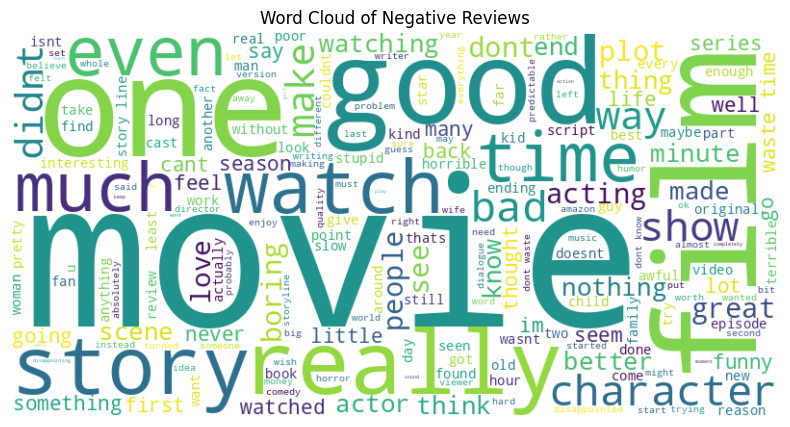

In [ ]:
neg_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show();

In [ ]:
def get_top_ngrams(text, ngram_range=(2,2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words="english")
    ngram_counts = vectorizer.fit_transform(text)
    ngram_sum = np.asarray(ngram_counts.sum(axis=0)).flatten()

    ngrams_freq = list(zip(vectorizer.get_feature_names_out(), ngram_sum))
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:n]

    return ngrams_freq

bigrams = get_top_ngrams(data["text"].astype(str), ngram_range=(2,2), n=10)
print("Top 10 Bigrams:", bigrams)

Top 10 Bigrams: [('great movie', 943), ('good movie', 930), ('story line', 451), ('love movie', 344), ('ve seen', 293), ('worth watching', 270), ('really enjoyed', 262), ('loved movie', 257), ('year old', 252), ('really good', 237)]


In [ ]:
# Bigrams dataframe
bigram_df = pd.DataFrame(bigrams, columns=["Bigram", "Frequency"])


In [ ]:
def plot_ngram_frequency(ngram_df, x_col="Frequency", y_col="Bigram", title="Top N-grams in Reviews", palette="Blues_r"):
    """
    Plots a bar chart of the most frequent n-grams.

    Parameters:
        ngram_df (DataFrame): A DataFrame containing n-grams and their frequencies.
        x_col (str, optional): The column name for frequency (default: "Frequency").
        y_col (str, optional): The column name for n-grams (default: "Bigram").
        title (str, optional): Title of the plot (default: "Top N-grams in Reviews").
        palette (str, optional): Color palette for the bar chart (default: "Blues_r").
    """
    plt.figure(figsize=(10, 5))
    sns.barplot(y=y_col, x=x_col, data=ngram_df, palette=palette)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col);

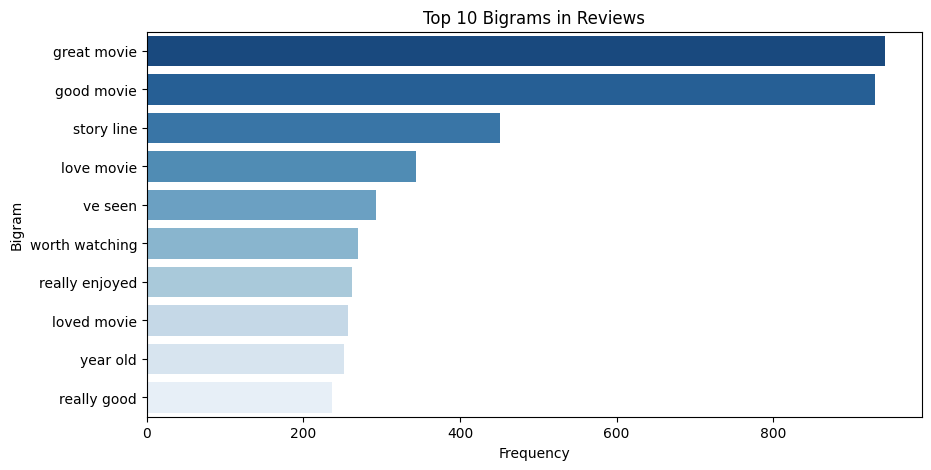

In [ ]:
plot_ngram_frequency(bigram_df, title="Top 10 Bigrams in Reviews")

In [ ]:
trigrams = get_top_ngrams(data["text"].astype(str), ngram_range=(3,3), n=10)
print("Top 10 Trigrams:", trigrams)

Top 10 Trigrams: [('did great job', 63), ('really enjoyed movie', 63), ('really good movie', 60), ('don waste time', 50), ('feel good movie', 47), ('good story line', 47), ('does great job', 45), ('movie ve seen', 44), ('based true story', 43), ('great story line', 43)]


In [ ]:
trigram_df = pd.DataFrame(trigrams, columns=["Trigram", "Frequency"])

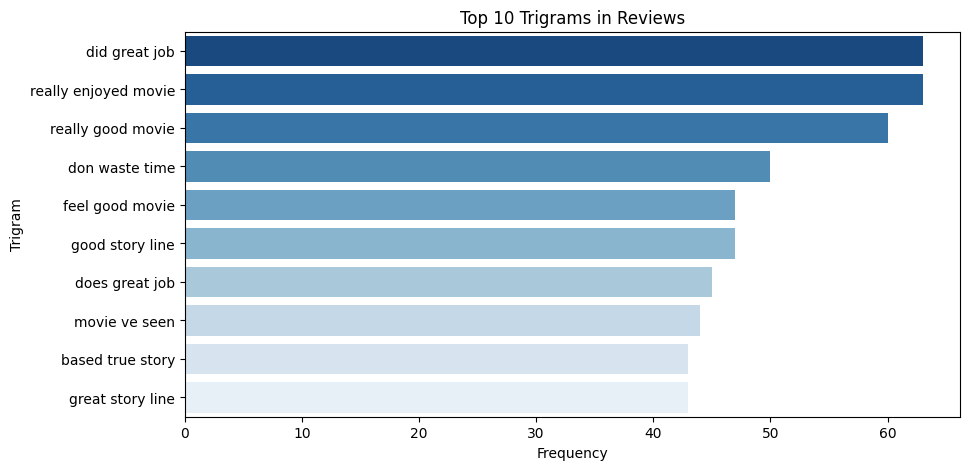

In [ ]:
plot_ngram_frequency(trigram_df, y_col="Trigram", title="Top 10 Trigrams in Reviews")

### Perform POS Tagging
- We'll extract the `most common nouns`, `adjectives`, and `verbs` to analyze the language used in reviews.

In [ ]:
# Load the English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def pos_tagging(text):
    doc = nlp(text)
    pos_counts = Counter(token.pos_ for token in doc)
    return pos_counts

In [ ]:
# Apply POS tagging to all reviews
data["pos_counts"] = data["text"].apply(pos_tagging)

In [ ]:
# Aggregate POS frequencies
pos_totals = Counter()
for pos_dict in data["pos_counts"]:
    pos_totals.update(pos_dict)

# Convert to DataFrame
pos_df = pd.DataFrame(pos_totals.items(), columns=["POS", "Count"])
pos_df = pos_df.sort_values(by="Count", ascending=False)

In [ ]:
pos_df.head(3)

,POS,Count
7,NOUN,169483
4,PUNCT,126344
5,VERB,112486


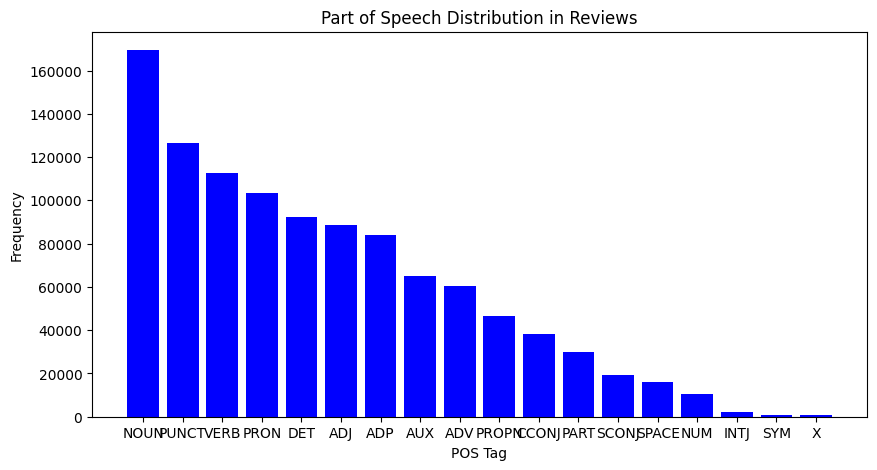

In [ ]:
# Plot POS distribution
plt.figure(figsize=(10, 5))
plt.bar(pos_df["POS"], pos_df["Count"], color="blue")
plt.title("Part of Speech Distribution in Reviews")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.show();

- This will show the most commonly used types of words (e.g., nouns, adjectives, verbs) in the reviews.

### Extract Most Common Nouns & Adjectives

In [ ]:
def extract_words(text, pos_type):
    doc = nlp(text)
    words = [token.text.lower() for token in doc if token.pos_ == pos_type and not token.is_stop]
    return words

In [ ]:
# Extract nouns
nouns = []
data["text"].apply(lambda x: nouns.extend(extract_words(x, "NOUN")))

,text
0,None
1,None
2,None
3,None
4,None
...,...
24107,None
24108,None
24109,None
24110,None


In [ ]:
nouns[0]

'scenes'

In [ ]:
# Extract adjectives
adjectives = []
data["text"].apply(lambda x: adjectives.extend(extract_words(x, "ADJ")))

,text
0,None
1,None
2,None
3,None
4,None
...,...
24107,None
24108,None
24109,None
24110,None


In [ ]:
adjectives[0]

'good'

In [ ]:
# Get top 10 most common nouns & adjectives
common_nouns = Counter(nouns).most_common(10)
common_adjectives = Counter(adjectives).most_common(10)

In [ ]:
common_nouns

[('movie', 11218),
 ('story', 3341),
 ('film', 2999),
 ('time', 2455),
 ('series', 1873),
 ('movies', 1583),
 ('season', 1536),
 ('characters', 1519),
 ('people', 1353),
 ('acting', 1190)]

In [ ]:
common_adjectives

[('good', 5319),
 ('great', 4878),
 ('funny', 1263),
 ('little', 1160),
 ('best', 1135),
 ('bad', 1083),
 ('interesting', 1017),
 ('better', 936),
 ('old', 915),
 ('worth', 908)]

In [ ]:
def generate_wordcloud(words, title="Word Cloud", width=800, height=400, background_color="white"):
    """
    Generates and displays a word cloud from a list of words (nouns, adjectives, etc.).

    Parameters:
        words (list): A list of extracted words (e.g., nouns or adjectives).
        title (str, optional): Title of the plot (default: "Word Cloud").
        width (int, optional): Width of the word cloud.
        height (int, optional): Height of the word cloud.
        background_color (str, optional): Background color.
    """
    # Join words into a single string
    text = " ".join(words)

    # Generate word cloud
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate(text)

    # Plot the word cloud
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    plt.title(title);

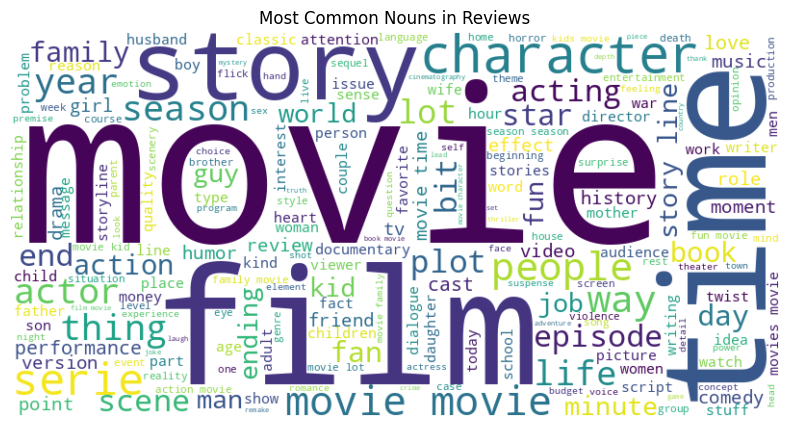

In [ ]:
generate_wordcloud(nouns, title="Most Common Nouns in Reviews")

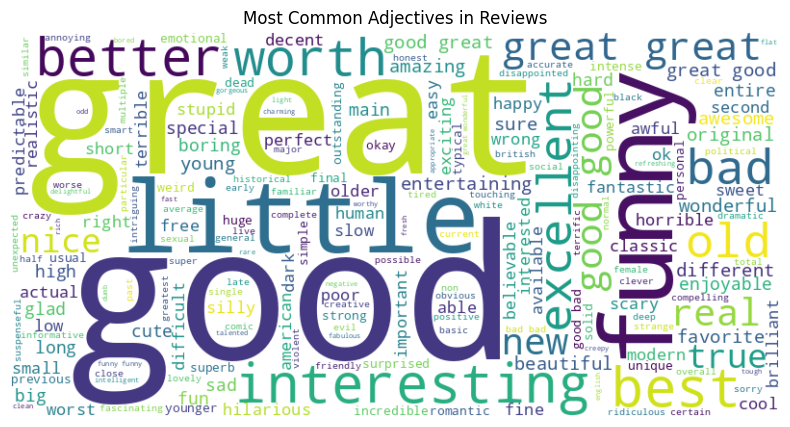

In [ ]:
generate_wordcloud(adjectives, title="Most Common Adjectives in Reviews")

In [ ]:
# Perform Train-Validation-Test Split (70-30 split first)
X_train, X_test, y_train, y_test = train_test_split(data["clean_review"], data["sentiment"], test_size=0.3, random_state=42, stratify=data["sentiment"])

# Further split train into Train (80%) and Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print dataset sizes
print(f"Train Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")

Train Set: 13502 samples
Validation Set: 3376 samples
Test Set: 7234 samples


In [ ]:
# Define the single pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("classifier", MultinomialNB())  # Placeholder for GridSearchCV
])

In [ ]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier', MultinomialNB())])

In [ ]:
# Evaluate the model
y_pred = pipeline.predict(X_val)
print("\nML Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))


ML Model Evaluation:
Accuracy: 0.7861374407582938


In [ ]:
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.21      0.34       463
     neutral       0.60      0.03      0.05       359
    positive       0.79      1.00      0.88      2554

    accuracy                           0.79      3376
   macro avg       0.74      0.41      0.42      3376
weighted avg       0.77      0.79      0.72      3376



### Observations

Positive class has the best performance

Precision = 0.79 (79% of predicted positive reviews are correct).

Recall = 1.00 (all actual positive reviews were correctly classified).

F1-Score = 0.88, indicating a strong performance.
Negative class has poor recall (0.21)

Many actual negative reviews are misclassified as neutral/positive.
But precision is high (0.84), meaning that when it predicts negative, it's often correct.

Neutral class performs worst

Precision = 0.60 (many false positives).

Recall = 0.03, meaning it rarely detects actual neutral reviews.
F1-score = 0.05, showing the model struggles with neutral sentiment.

### Overall Performance Metrics

Accuracy = 0.79 (79%)

The model correctly classified 79% of all reviews.
Macro Avg (Average across all classes, equal weight)

Precision = 0.74

Recall = 0.41 (low recall shows poor negative & neutral detection).

F1-Score = 0.42 (imbalanced class performance).
Weighted Avg (Accounts for class distribution)

Favors the positive class (largest group).

F1-score = 0.72, meaning overall model performance is decent but not balanced across classes.

### Key Takeaways
- Neutral detection is weak → Model rarely identifies neutral reviews correctly.
- Negative recall is low → Many actual negative reviews are misclassified.
- Positive sentiment is detected well → Strong performance for positive reviews.
- Accuracy (79%) is decent, but F1-score (0.72) suggests class imbalance issues.

In [ ]:
# Define parameter grid
param_grid = [
    {
        "tfidf__ngram_range": [(1,1), (1,2)],  # Unigrams & Bigrams
        "classifier": [MultinomialNB()],
        "classifier__alpha": [0.1, 0.5, 1.0]  # Smoothing parameter for Naïve Bayes
    },
    {
        "tfidf__ngram_range": [(1,1), (1,2)],  # Unigrams & Bigrams
        "classifier": [SVC()],
        "classifier__C": [0.1, 1, 10],  # Regularization strength for SVM
        "classifier__kernel": ["linear", "rbf"]  # Kernel types
    }
]

In [ ]:
# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1.0],
                          'tfidf__ngram_range': [(1, 1), (1, 2)]},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'tfidf__ngram_range': [(1, 1), (1, 2)]}],
             scoring='accuracy', verbose=1)

In [ ]:
# Get best model
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier', SVC(C=1, kernel='linear'))])

In [ ]:
# Make predictions on test set
y_pred = best_model.predict(X_val)

In [ ]:
print("Accuracy on validation Set:", accuracy_score(y_val, y_pred))

Accuracy on validation Set: 0.8228672985781991


In [ ]:

# Assuming `svm_pipeline` is your trained pipeline containing both the vectorizer and SVM model
joblib.dump(best_model, "/content/drive/MyDrive/capstone/svm_model.pkl")

print("SVM pipeline (model + vectorizer) saved successfully!")

SVM pipeline (model + vectorizer) saved successfully!


### Neural network models

In [ ]:
data.shape

(24112, 16)

In [ ]:
data.to_csv('/content/drive/MyDrive/capstone/data.csv', index=False)